# Vaccine Adverse Event Reporting System #

## Introduction ##

- The Vaccine Adverse Event Reporting System (VAERS) was created by the Food and Drug Administration (FDA) and Centers for Disease Control and Prevention (CDC) to receive reports about adverse events that may be associated with vaccines. 


- No prescription drug or biological product, such as a vaccine, is completely free from side effects. Vaccines protect many people from dangerous illnesses, but vaccines, like drugs, can cause side effects, a small percentage of which may be serious. 


- VAERS researchers apply procedures and methods of data analysis to help us closely monitor the safety of vaccines.


- Data Analysis is the process of systematically applying statistical and/or logical techniques to describe, illustrate, condense and evaluate data. 


- Analytic procedures provide a way of drawing inductive inferences from data and distinguishing the signal (the phenomenon of interest) from the noise (statistical fluctuations) present in the data.


- While data analysis in qualitative research, it includes statistical procedures.Many times, analysis becomes an ongoing iterative process where data is continuously collected and analyzed almost simultaneously.


- Indeed, researchers generally analyze for patterns in observations through the entire data collection phase (Savenye, Robinson, 2004). 


- The form of the analysis is determined by the specific qualitative approach taken (field study, ethnography content analysis, oral history, biography, unobtrusive research) and the form of the data (field notes, documents, audiotape, videotape). 


- An essential component of ensuring data integrity is the accurate and appropriate analysis of research findings. 

 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import dabl
import warnings
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer

pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data Exploration ##


First we start by reading data from the 3 files:

    - VAERS data
    - VAERS Symptoms
    - VAERS Vaccination
    
    

In [15]:
# pd.show_versions()

In [26]:
def read_vaers_data(filename):
    return pd.read_csv(filename, encoding='iso-8859-1', low_memory=False, memory_map=True)

data = read_vaers_data('2021VAERSDATA.csv')
symptoms = read_vaers_data('2021VAERSSYMPTOMS.csv')
vax = read_vaers_data('2021VAERSVAX.csv')

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624237 entries, 0 to 624236
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   VAERS_ID      624237 non-null  int64  
 1   RECVDATE      624237 non-null  object 
 2   STATE         545651 non-null  object 
 3   AGE_YRS       558105 non-null  float64
 4   CAGE_YR       499906 non-null  float64
 5   CAGE_MO       2654 non-null    float64
 6   SEX           624237 non-null  object 
 7   RPT_DATE      350 non-null     object 
 8   SYMPTOM_TEXT  624093 non-null  object 
 9   DIED          8083 non-null    object 
 10  DATEDIED      7209 non-null    object 
 11  L_THREAT      9596 non-null    object 
 12  ER_VISIT      52 non-null      object 
 13  HOSPITAL      37870 non-null   object 
 14  HOSPDAYS      25656 non-null   float64
 15  X_STAY        329 non-null     object 
 16  DISABLE       9861 non-null    object 
 17  RECOVD        567220 non-null  object 
 18  VAX_

In [29]:
symptoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834197 entries, 0 to 834196
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         834197 non-null  int64  
 1   SYMPTOM1         834197 non-null  object 
 2   SYMPTOMVERSION1  834197 non-null  float64
 3   SYMPTOM2         652791 non-null  object 
 4   SYMPTOMVERSION2  652791 non-null  float64
 5   SYMPTOM3         503851 non-null  object 
 6   SYMPTOMVERSION3  503851 non-null  float64
 7   SYMPTOM4         382172 non-null  object 
 8   SYMPTOMVERSION4  382172 non-null  float64
 9   SYMPTOM5         284369 non-null  object 
 10  SYMPTOMVERSION5  284369 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 70.0+ MB


In [30]:
vax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655560 entries, 0 to 655559
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   VAERS_ID         655560 non-null  int64 
 1   VAX_TYPE         655560 non-null  object
 2   VAX_MANU         655560 non-null  object
 3   VAX_LOT          450286 non-null  object
 4   VAX_DOSE_SERIES  652416 non-null  object
 5   VAX_ROUTE        500908 non-null  object
 6   VAX_SITE         480239 non-null  object
 7   VAX_NAME         655560 non-null  object
dtypes: int64(1), object(7)
memory usage: 40.0+ MB


In [31]:
pd.set_option('display.max_columns', None)
symptoms.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,Dysphagia,23.10000,Epiglottitis,23.10000,NaN,NaN,NaN,NaN,NaN,NaN
1,916601,Anxiety,23.10000,Dyspnoea,23.10000,NaN,NaN,NaN,NaN,NaN,NaN
2,916602,Chest discomfort,23.10000,Dysphagia,23.10000,Pain in extremity,23.10000,Visual impairment,23.10000,NaN,NaN
3,916603,Dizziness,23.10000,Fatigue,23.10000,Mobility decreased,23.10000,NaN,NaN,NaN,NaN
4,916604,Injection site erythema,23.10000,Injection site pruritus,23.10000,Injection site swelling,23.10000,Injection site warmth,23.10000,NaN,NaN


In [32]:
symptoms.isnull().sum()

VAERS_ID                0
SYMPTOM1                0
SYMPTOMVERSION1         0
SYMPTOM2           181406
SYMPTOMVERSION2    181406
SYMPTOM3           330346
SYMPTOMVERSION3    330346
SYMPTOM4           452025
SYMPTOMVERSION4    452025
SYMPTOM5           549828
SYMPTOMVERSION5    549828
dtype: int64

In [33]:
imputer = SimpleImputer(strategy='most_frequent')
symptoms.iloc[:,:] = imputer.fit_transform(symptoms)

In [42]:
VAERS = data.merge(vax, on='VAERS_ID', how='inner')
VAERS.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916600,01/01/2021,TX,33.00000,33.00000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/30/2020,2.00000,None,PVT,NaN,None,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916601,01/01/2021,CA,73.00000,73.00000,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/31/2020,12/31/2020,0.00000,NaN,SEN,NaN,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy""",COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
2,916602,01/01/2021,WA,23.00000,23.00000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2020,12/31/2020,0.00000,NaN,SEN,NaN,None,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916603,01/01/2021,WA,58.00000,58.00000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/23/2020,12/23/2020,0.00000,none,WRK,NaN,none,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA))
4,916604,01/01/2021,TX,47.00000,47.00000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/22/2020,12/29/2020,7.00000,NaN,PUB,NaN,Na,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))


In [43]:
SYM = vax.merge(symptoms, on='VAERS_ID', how='inner')
SYM.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),Dysphagia,23.10000,Epiglottitis,23.10000,Headache,24.00000,Pyrexia,24.00000,Pyrexia,24.00000
1,916601,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),Anxiety,23.10000,Dyspnoea,23.10000,Headache,24.00000,Pyrexia,24.00000,Pyrexia,24.00000
2,916602,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,23.10000,Dysphagia,23.10000,Pain in extremity,23.10000,Visual impairment,23.10000,Pyrexia,24.00000
3,916603,COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA)),Dizziness,23.10000,Fatigue,23.10000,Mobility decreased,23.10000,Pyrexia,24.00000,Pyrexia,24.00000
4,916604,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA)),Injection site erythema,23.10000,Injection site pruritus,23.10000,Injection site swelling,23.10000,Injection site warmth,23.10000,Pyrexia,24.00000


In [45]:
grouped_symptoms = SYM.sort_values(["VAX_NAME"], ascending=True).groupby(["VAX_NAME"])[["VAX_NAME", "SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]]
grouped_symptoms.head(20)

,VAX_NAME,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
198635,"ADENOVIRUS TYPES 4 & 7, LIVE, ORAL (NO BRAND N...",Chills,Diarrhoea,Product administered to patient of inappropria...,Pyrexia,Pyrexia
804380,"ADENOVIRUS TYPES 4 & 7, LIVE, ORAL (NO BRAND N...",Nausea,Throat tightness,Vomiting,Pyrexia,Pyrexia
252453,"ADENOVIRUS TYPES 4 & 7, LIVE, ORAL (NO BRAND N...",Arthralgia,Chills,Fatigue,Headache,Myalgia
18589,"ADENOVIRUS TYPES 4 & 7, LIVE, ORAL (NO BRAND N...",Muscle fatigue,Nasal congestion,Headache,Pyrexia,Pyrexia
468410,"ADENOVIRUS TYPES 4 & 7, LIVE, ORAL (NO BRAND N...",Photophobia,Pyrexia,Sleep disorder,Pyrexia,Pyrexia
...,...,...,...,...,...,...
163828,ZOSTER LIVE (ZOSTAVAX),Herpes zoster,Neurological symptom,Parkinson's disease,Post herpetic neuralgia,Visual impairment
553128,ZOSTER LIVE (ZOSTAVAX),Cardiac failure congestive,Herpes zoster,Headache,Pyrexia,Pyrexia
199394,ZOSTER LIVE (ZOSTAVAX),Balance disorder,Bell's palsy,Blister,Deafness,Ear pain
83650,ZOSTER LIVE (ZOSTAVAX),Grip strength decreased,Herpes zoster,Musculoskeletal stiffness,Nerve injury,Pain in extremity


Target looks like regression


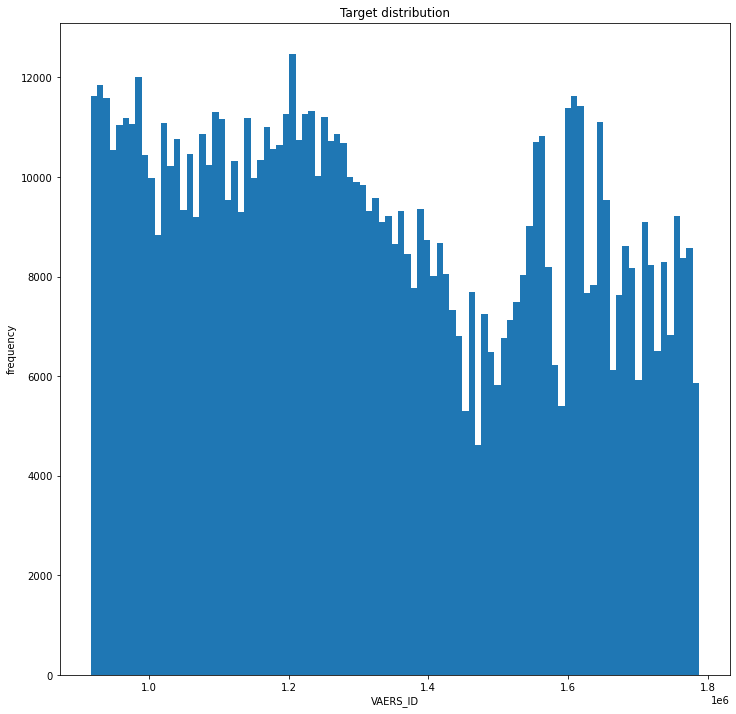

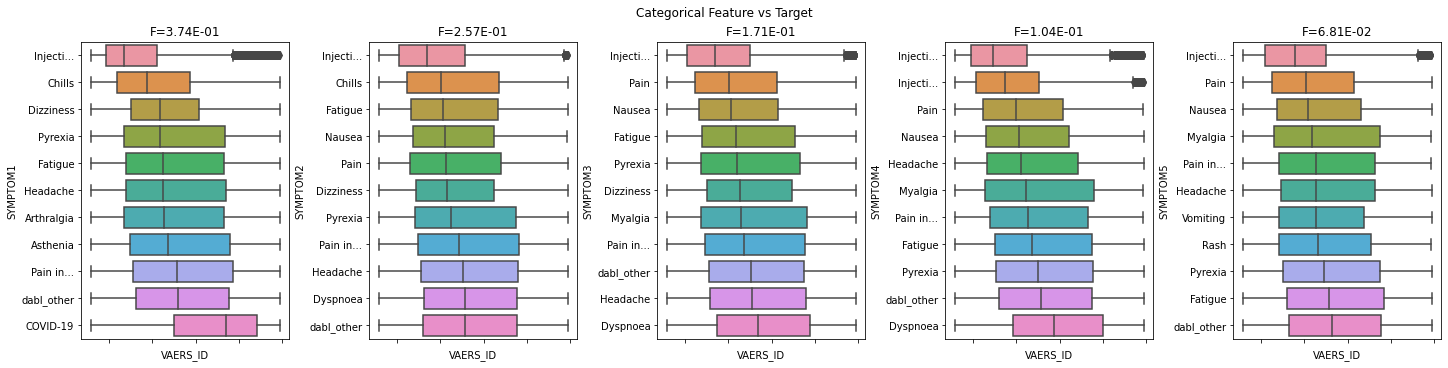

In [64]:
################# frequency of symptoms for each vaccine #############################

new_df = SYM[['VAERS_ID', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']]
dabl.plot(new_df, target_col='VAERS_ID')
warnings.filterwarnings("ignore")

<AxesSubplot:title={'center':'Correlation Heatmap'}>

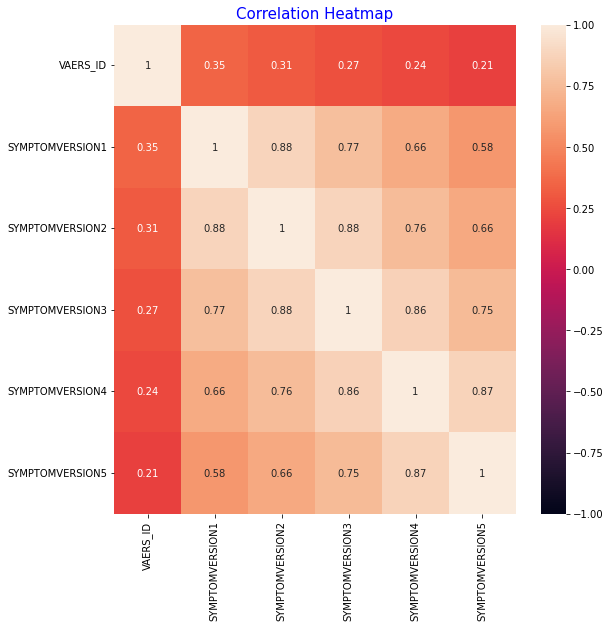

In [63]:
################# correlation between symptoms and vaccine #############################

plt.figure(figsize = (9,9))
plt.title("Correlation Heatmap",color = 'blue',fontsize=15)
sns.heatmap(SYM.corr(), vmin=-1, vmax=1, annot=True)

In [65]:
####################### merging all the three VAERS data files into one dataframe #########################

DATA = VAERS.merge(symptoms, on='VAERS_ID', how='inner')
DATA.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,01/01/2021,TX,33.00000,33.00000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/30/2020,2.00000,None,PVT,NaN,None,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),Dysphagia,23.10000,Epiglottitis,23.10000,Headache,24.00000,Pyrexia,24.00000,Pyrexia,24.00000
1,916601,01/01/2021,CA,73.00000,73.00000,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/31/2020,12/31/2020,0.00000,NaN,SEN,NaN,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy""",COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),Anxiety,23.10000,Dyspnoea,23.10000,Headache,24.00000,Pyrexia,24.00000,Pyrexia,24.00000
2,916602,01/01/2021,WA,23.00000,23.00000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2020,12/31/2020,0.00000,NaN,SEN,NaN,None,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,23.10000,Dysphagia,23.10000,Pain in extremity,23.10000,Visual impairment,23.10000,Pyrexia,24.00000
3,916603,01/01/2021,WA,58.00000,58.00000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/23/2020,12/23/2020,0.00000,none,WRK,NaN,none,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA)),Dizziness,23.10000,Fatigue,23.10000,Mobility decreased,23.10000,Pyrexia,24.00000,Pyrexia,24.00000
4,916604,01/01/2021,TX,47.00000,47.00000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/22/2020,12/29/2020,7.00000,NaN,PUB,NaN,Na,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA)),Injection site erythema,23.10000,Injection site pruritus,23.10000,Injection site swelling,23.10000,Injection site warmth,23.10000,Pyrexia,24.00000


In [58]:
######################### filtering covid vaccine data based on manufacturers ################################

mod = DATA[DATA['VAX_MANU'] =='MODERNA'].copy()
pf =  DATA[DATA['VAX_MANU'] =='PFIZER\BIONTECH'].copy()
Jns = DATA[DATA['VAX_MANU'] =='JANSSEN'].copy()

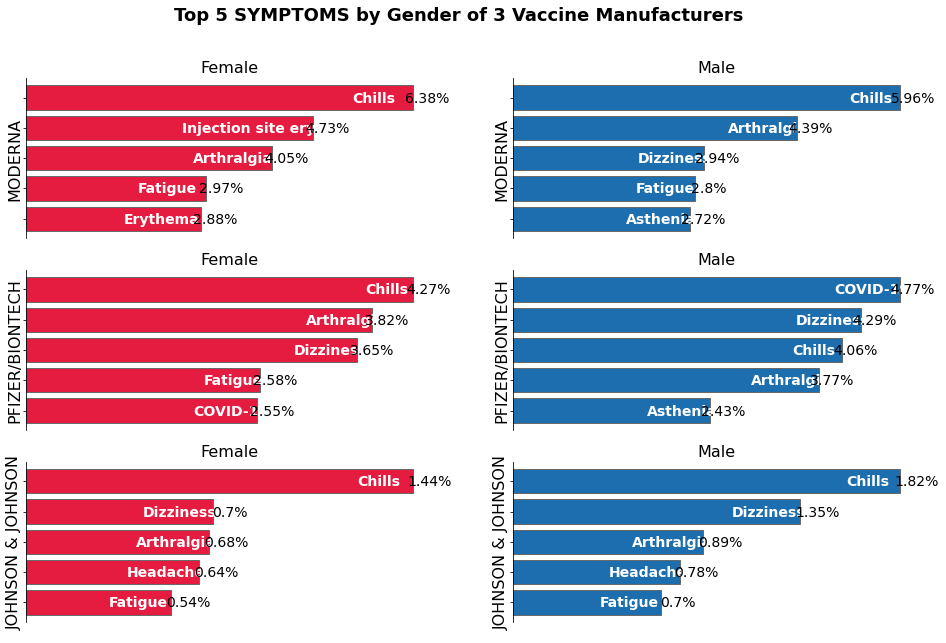

In [68]:
############## Top 5 SYMPTOMs by Gender for each of the 3 Vaccine Manufacturers of COVID vaccine #############

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))

##################################### MODERNA #######################################

female = mod[mod['SEX'] == 'F']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)
male = mod[mod['SEX'] == 'M']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)

ax[0,0].barh(female.index, width=female.values, color='#E51B40', edgecolor='dimgray')

for i in range(0,5):
    ax[0,0].annotate(list(female.index)[i], xy=(female.values[i]-1800,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((female.values[i]/mod['SEX'].value_counts()[0])*100, 2)
    annot = annot.astype('str')
    ax[0,0].annotate(annot+'%', xy=(female.values[i]+675,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[0,0].set_ylabel('MODERNA', fontsize=16)
ax[0,0].set_title('Female', fontsize=16)

ax[0,1].barh(male.index, width=male.values, color='#1D6EAE', edgecolor='dimgray')
for i in range(0,5):
    ax[0,1].annotate(list(male.index)[i], xy=(male.values[i]-450,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((male.values[i]/mod['SEX'].value_counts()[1])*100, 2)
    annot = annot.astype('str')
    ax[0,1].annotate(annot+'%', xy=(male.values[i]+210,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[0,1].set_ylabel('MODERNA', fontsize=16)
ax[0,1].set_title('Male', fontsize=16)

############################ PFIZER/BIONTECH ################################

female = pf[pf['SEX'] == 'F']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)
male = pf[pf['SEX'] == 'M']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)

ax[1,0].barh(female.index, width=female.values, color='#E51B40', edgecolor='dimgray')

for i in range(0,5):
    ax[1,0].annotate(list(female.index)[i], xy=(female.values[i]-800,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((female.values[i]/mod['SEX'].value_counts()[0])*100, 2)
    annot = annot.astype('str')
    ax[1,0].annotate(annot+'%', xy=(female.values[i]+475,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[1,0].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,0].set_title('Female', fontsize=16)

ax[1,1].barh(male.index, width=male.values, color='#1D6EAE', edgecolor='dimgray')
for i in range(0,5):
    ax[1,1].annotate(list(male.index)[i], xy=(male.values[i]-350,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((male.values[i]/mod['SEX'].value_counts()[1])*100, 2)
    annot = annot.astype('str')
    ax[1,1].annotate(annot+'%', xy=(male.values[i]+160,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[1,1].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,1].set_title('Male', fontsize=16)

############################### JOHNSON and JOHNSON ########################################

female = Jns[Jns['SEX'] == 'F']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)
male = Jns[Jns['SEX'] == 'M']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)

ax[2,0].barh(female.index, width=female.values, color='#E51B40', edgecolor='dimgray')

for i in range(0,5):
    ax[2,0].annotate(list(female.index)[i], xy=(female.values[i]-350,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((female.values[i]/mod['SEX'].value_counts()[0])*100, 2)
    annot = annot.astype('str')
    ax[2,0].annotate(annot+'%', xy=(female.values[i]+175,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[2,0].set_ylabel('JOHNSON & JOHNSON', fontsize=16)
ax[2,0].set_title('Female', fontsize=16)

ax[2,1].barh(male.index, width=male.values, color='#1D6EAE', edgecolor='dimgray')
for i in range(0,5):
    ax[2,1].annotate(list(male.index)[i], xy=(male.values[i]-150,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((male.values[i]/mod['SEX'].value_counts()[1])*100, 2)
    annot = annot.astype('str')
    ax[2,1].annotate(annot+'%', xy=(male.values[i]+80,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[2,1].set_ylabel('JOHNSON & JOHNSON', fontsize=16)
ax[2,1].set_title('Male', fontsize=16)

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].tick_params(axis='y', labelleft=False)
        ax[i,j].tick_params(axis='x', bottom=False, labelbottom=False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].set_xlabel(" ")


plt.suptitle('Top 5 SYMPTOMS by Gender of 3 Vaccine Manufacturers', fontsize=18, fontweight='bold')
plt.show()